In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Loading in Data + Cleaning

In [2]:
source = 'https://aisgaiap.blob.core.windows.net/aiap6-assessment-data/scooter_rental_data.csv'
df = pd.read_csv(source)
df.head()

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,-2,10


Intention: 
1. To convert date-time data into a YYYY-MM-DD HH:MM:SS format
2. Then use this as the index for the dataframe

In [3]:
# Cleaning up the hr column by making it look more like date-time format
df['hr'] = df['hr'].apply(lambda x : str(x) + ':00:00')

# Combining the dates and hour columns and adding a space in between them
df['date-time'] = df['date'] + ' ' + df['hr']

# Converting the combined column into a date-time format
df['date-time'] = pd.to_datetime(df['date-time'])

# Setting the newly created date-time column as the index
df.index = df['date-time']

# Dropping the original date and hour columns
df = df.drop(['date', 'hr', 'date-time'], axis=1)

df.head()

,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
date-time,,,,,,,,
2011-01-01 00:00:00,clear,66.7,95.0,81.0,0.0,3,21,164
2011-01-01 01:00:00,clear,65.0,93.2,80.0,0.0,35,54,417
2011-01-01 02:00:00,clear,65.0,93.2,80.0,0.0,38,35,356
2011-01-01 03:00:00,clear,66.7,95.0,75.0,0.0,35,19,129
2011-01-01 04:00:00,clear,66.7,95.0,75.0,0.0,11,-2,10


Action:
1. Check the unique values of the weather column
2. Clean up where there are repeats under different tags or duplicates

We can see that there are a few problems here:
1. clear, CLEAR and lear I supposed are all meant to be tagged as clear
2. cloudy, loudy and CLOUDLY are also meant to be tagged as the same under cloudy
3. Same for light snow/rain & LIGHT SNOW/RAIN

This resulted in more than necessary categories of weather when there are actually just 4 categories.

In [4]:
df.weather.unique()

array(['clear', 'cloudy', 'light snow/rain', 'loudy', 'lear', 'CLEAR',
       'CLOUDY', 'heavy snow/rain', 'LIGHT SNOW/RAIN'], dtype=object)

In [5]:
# Creating a temporary list to store the new weather values
# Then iterate through the weather column, replacing them with the correct one
temp_list = []
for weather in df['weather']:
    if weather == 'clear' or weather == 'lear' or weather == 'CLEAR':
        temp_list.append('clear')
    
    elif weather == 'cloudy' or weather == 'loudy' or weather == 'CLOUDY':
        temp_list.append('cloudy')
    
    elif weather == 'light snow/rain' or weather == 'LIGHT SNOW/RAIN':
        temp_list.append('light snow/rain')
    
    else:
        temp_list.append('heavy snow/rain')

# Replacing old weather column with the new list
df['weather'] = temp_list
df['weather'].unique()

array(['clear', 'cloudy', 'light snow/rain', 'heavy snow/rain'],
      dtype=object)

Let's make a new column for total number of users since that is the target variable specified in the requirements.

In [6]:
# Adding the registered-users and guest-users column together to form the total_users column
df['total_users'] = df['registered-users'] + df['guest-users']

# Dropping the guest and registered users columns
df = df.drop(['registered-users', 'guest-users'], axis=1)

df.head()

,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,total_users
date-time,,,,,,,
2011-01-01 00:00:00,clear,66.7,95.0,81.0,0.0,3,185
2011-01-01 01:00:00,clear,65.0,93.2,80.0,0.0,35,471
2011-01-01 02:00:00,clear,65.0,93.2,80.0,0.0,38,391
2011-01-01 03:00:00,clear,66.7,95.0,75.0,0.0,35,148
2011-01-01 04:00:00,clear,66.7,95.0,75.0,0.0,11,8


# 2. Exploration of Data

Seems like there is only one categorical feature in the dataset (weather). The rest are continuous features.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17958 entries, 2011-01-01 00:00:00 to 2012-04-29 10:00:00
Data columns (total 7 columns):
weather                   17958 non-null object
temperature               17958 non-null float64
feels-like-temperature    17958 non-null float64
relative-humidity         17958 non-null float64
windspeed                 17958 non-null float64
psi                       17958 non-null int64
total_users               17958 non-null int64
dtypes: float64(4), int64(2), object(1)
memory usage: 1.1+ MB


Let's plot out the features to see how they look graphically

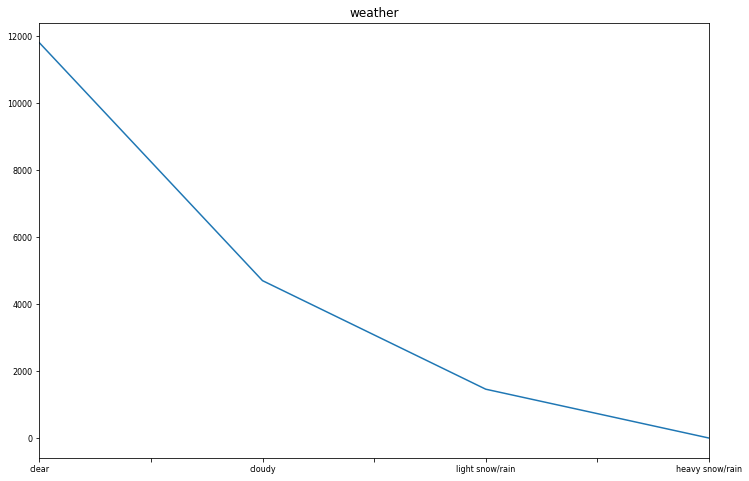

In [8]:
for column in df.columns:
    if column == 'weather':
        plt.figure(column, figsize=(12,8))
        plt.tick_params(axis='both', which='major', labelsize=8)
        plt.title(column)
        df[column].value_counts().plot()

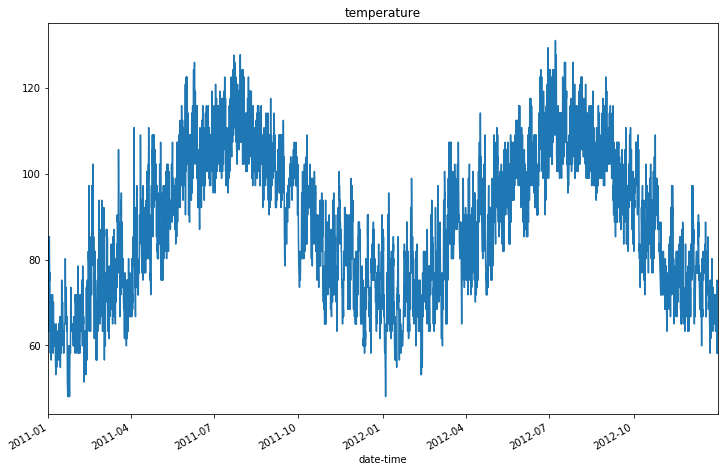

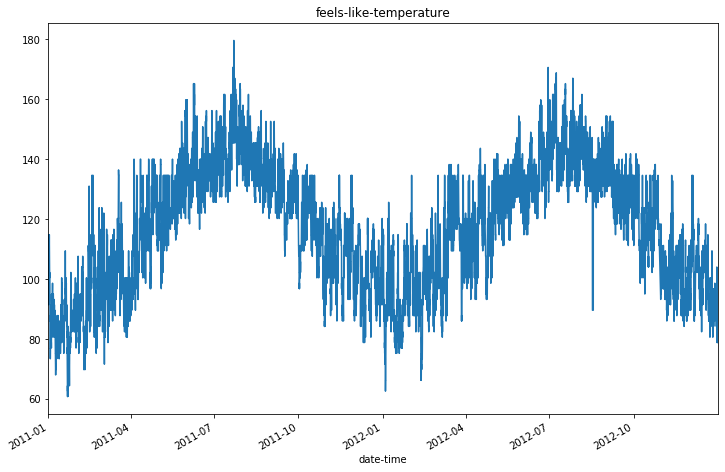

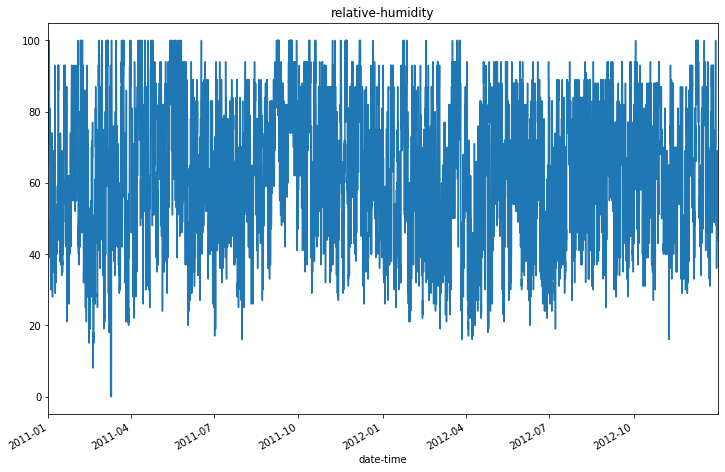

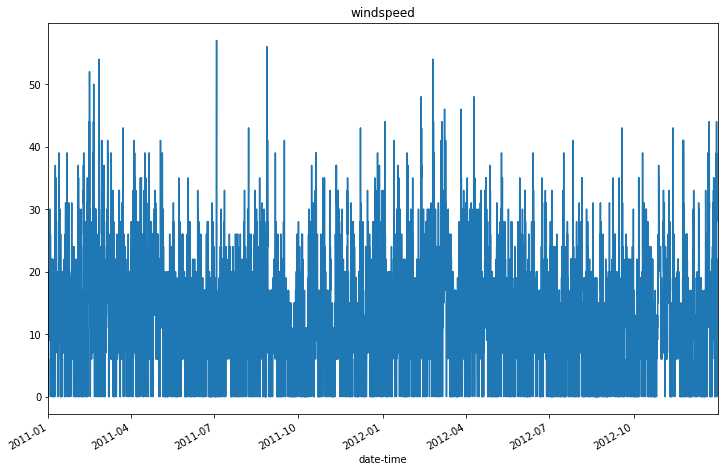

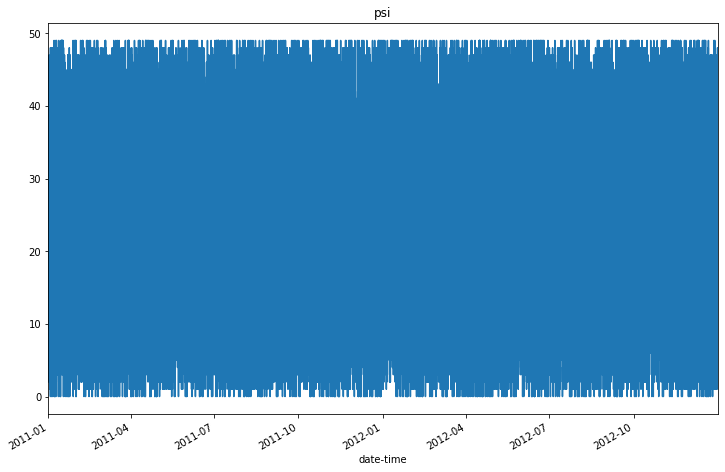

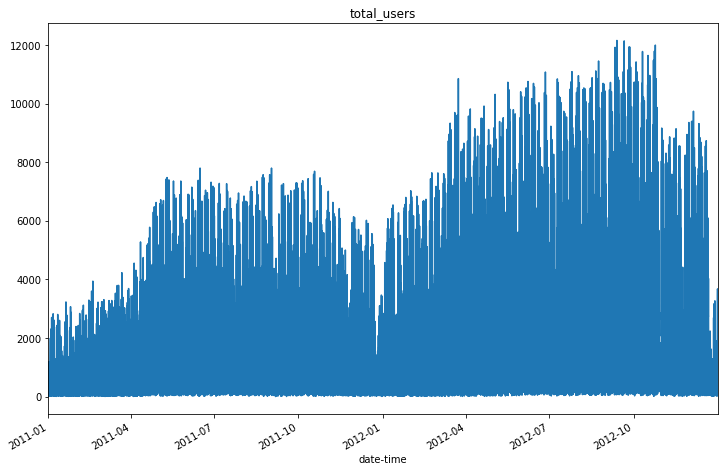

In [9]:
for column in df.columns:
    if column != 'weather':
        plt.figure(column, figsize=(12,8))
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.title(column)
        df[column].plot()

Let's take a closer look at humidity by shrinking the timeframe since we can't really see anything by plotting the entire dataset. We're gonna split it into first month, first quarter and first 6 months 

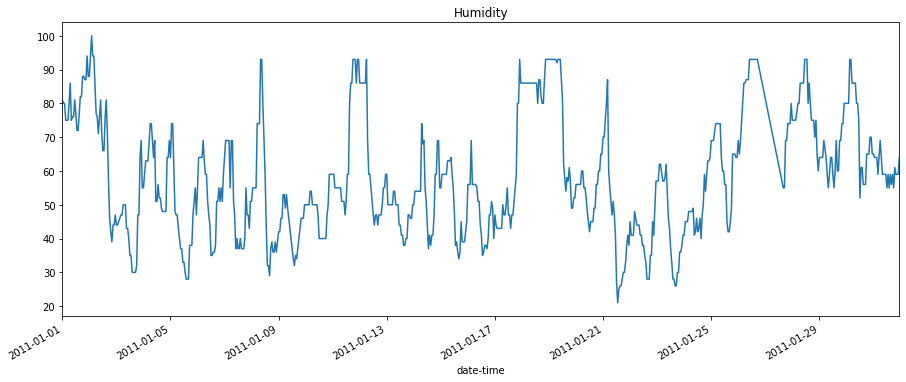

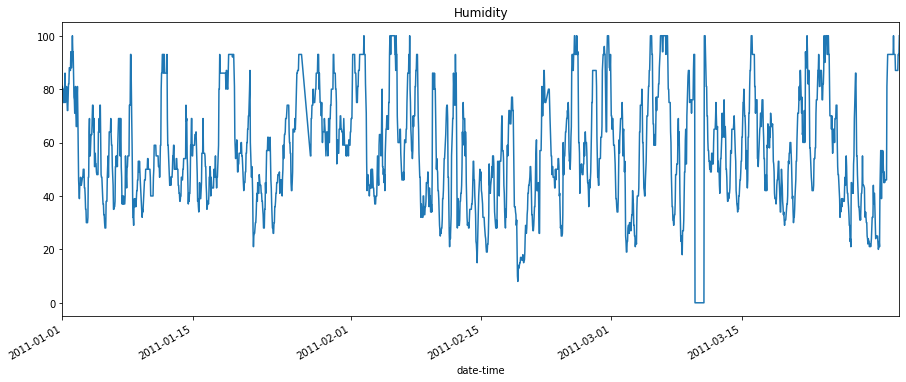

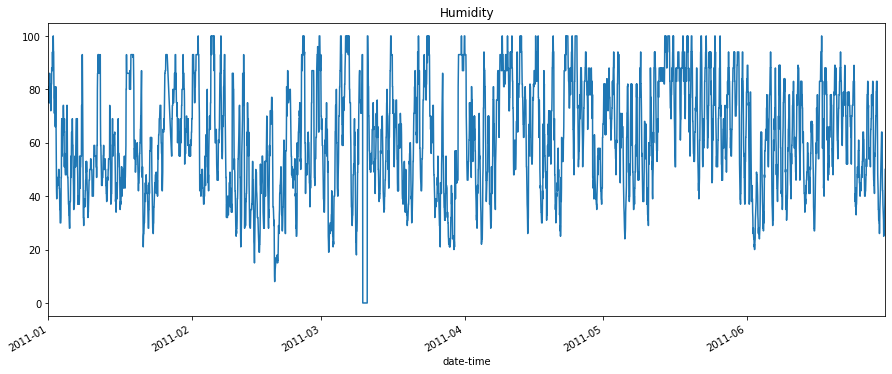

In [10]:
dates = ['2011-01', '2011-03', '2011-06']
for enddate in dates:
    plt.figure(figsize=(15,6))
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title('Humidity')
    df['relative-humidity'].loc['2011-01':enddate].plot()

Let's do the same for windspeed and psi.

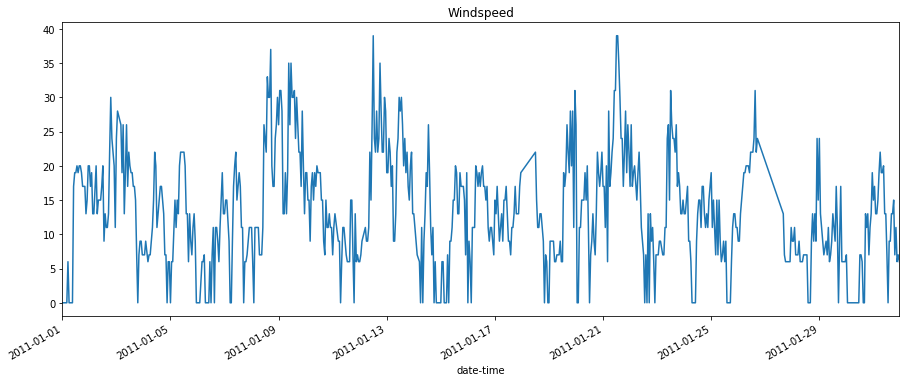

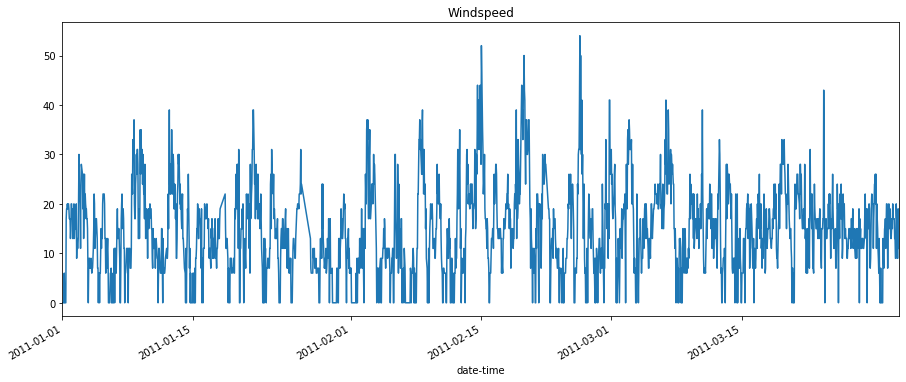

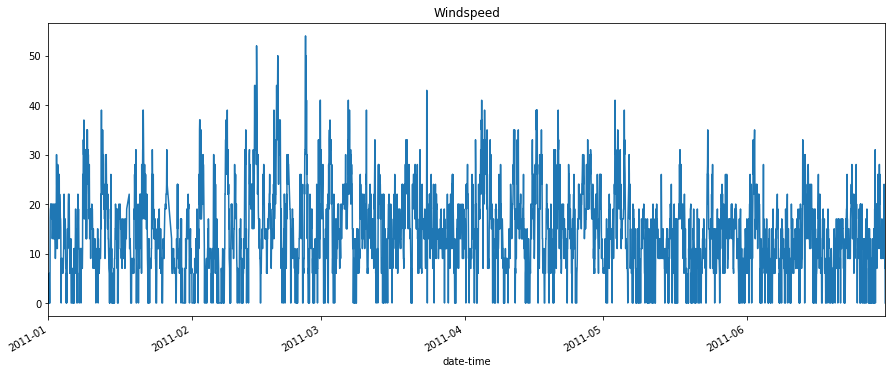

In [11]:
for enddate in dates:
    plt.figure(figsize=(15,6))
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title('Windspeed')
    df['windspeed'].loc['2011-01':enddate].plot()

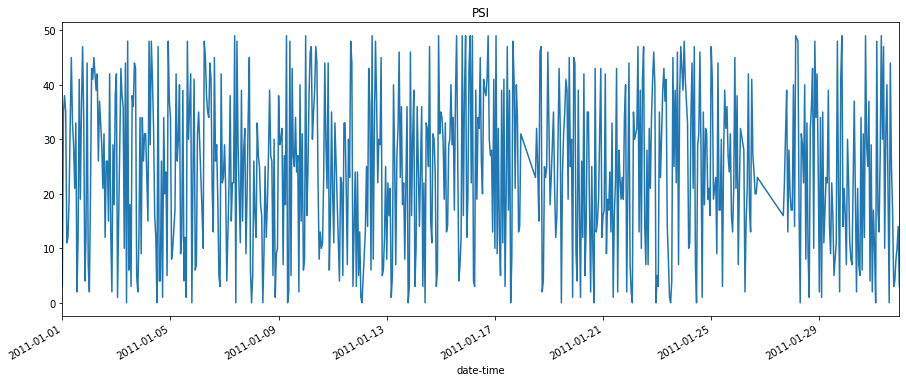

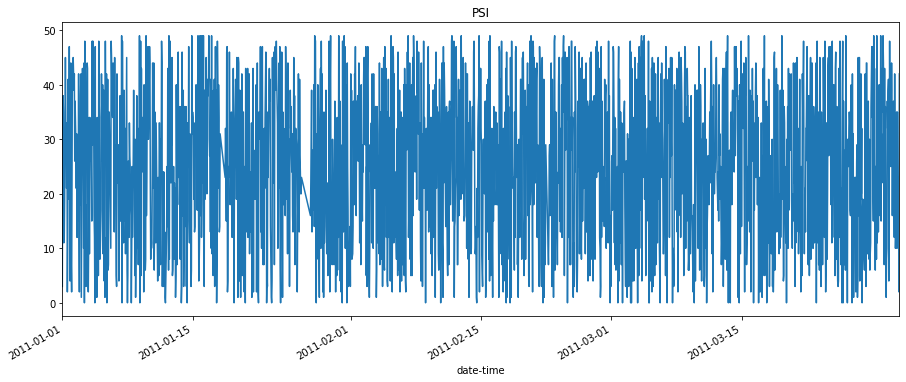

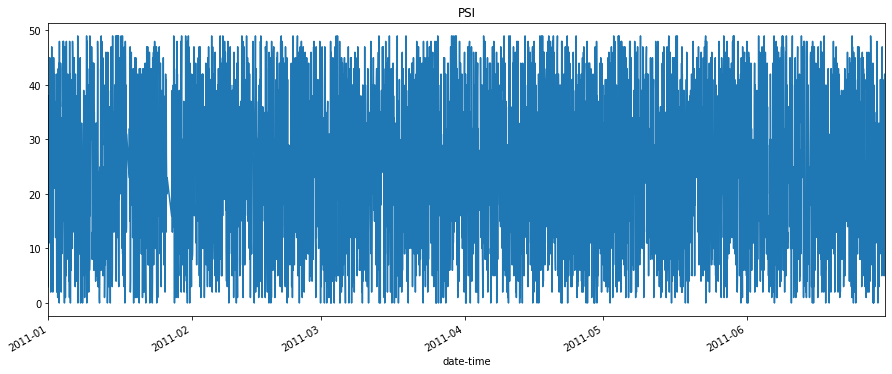

In [12]:
for enddate in dates:
    plt.figure(figsize=(15,6))
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title('PSI')
    df['psi'].loc['2011-01':enddate].plot()

Let's also examine toal users in greater detail. I suspect number of users will have peaks depending on holidays, so let's also look at 1 year's span of data.

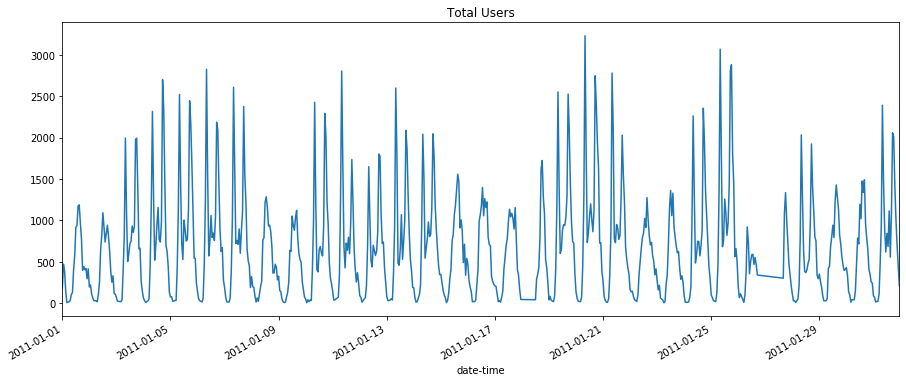

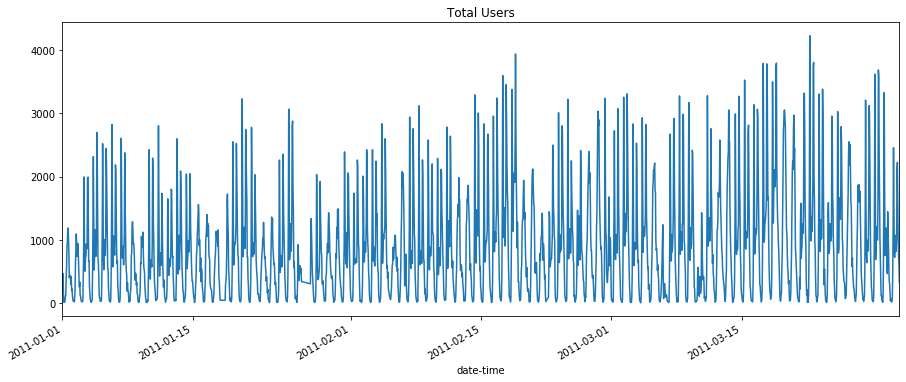

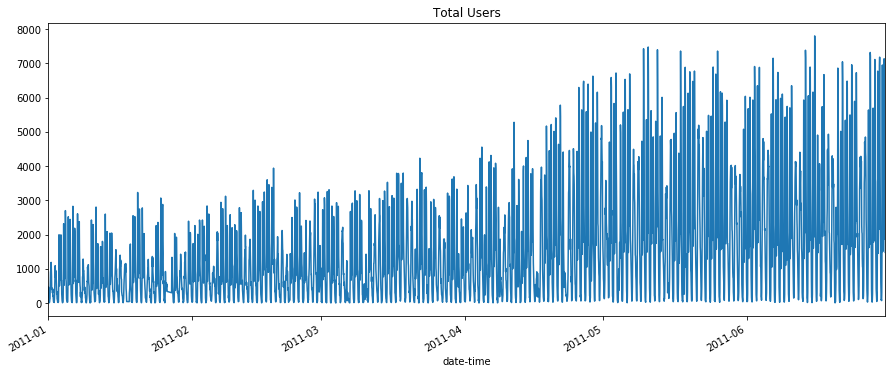

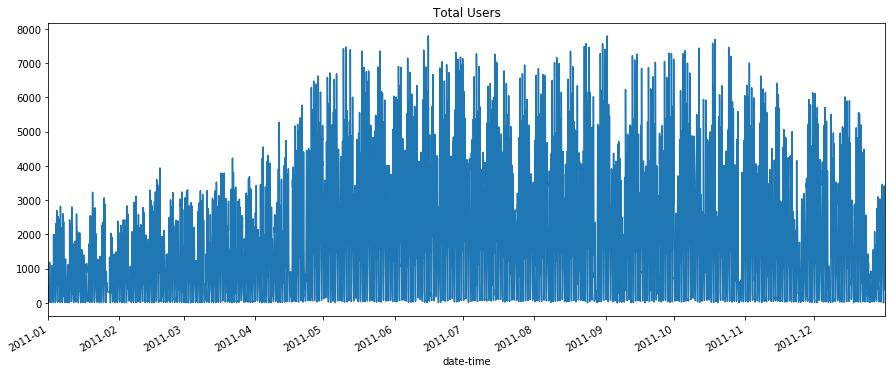

In [13]:
dates.append('2011-12')
for enddate in dates:
    plt.figure(figsize=(15,6))
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title('Total Users')
    df['total_users'].loc['2011-01':enddate].plot()

## Weather
Seems to show a rather common sense pattern - When weather is clear, more people are likely to rent an e-scooter. It doesn't make sense to ride an e-scooter when weather is bad (E.g. raining/snowing). Cloudy weather will definitely have less than clear weather because people usually take cloudy weather as a sign that it is going to rain.

## Temperature
There is a seasonal pattern to weather - Start of year low temperatures, temperatures start to rise close to mid-year, then start to fall as end-year approaches.

## Feels-like-temperature    
Same pattern as temperature. Makes sense as feels-like-temperature is strongly related to temperature. I'll probably just use one between the two temperatures to avoid multi-colinearity. Also, I'll pick feels-like-temperature as afterall we're trying to predict e-scooter rental. Its more likely that the rental will be affected that what the temperature feels like as compared to actual temperature.

## Relative-humidity     
Seems to be no discernable pattern here. Maybe at most can say that there is a weekly seasonal pattern but seems unlikely.

## Windspeed      
Also seems to have no discernable trend or seasonality here.

## Psi                       
Psi seems to be stationary.

## Total_users
Appears to have a seasonal pattern based months and hours. Months that fall within holiday periods seems to have a higher number of guest users. Certain hours in the day also have significantly more users.
Also, total number of users seem to be trending upwards from 2011 - 2012.

# 3. Relationship between Target & Predictors

Let's first take a look at how the continuous features correlates with number of total users.

1. Windspeed has close to no correlation to total users.
2. Same for PSI.
3. Temperature and humidity has rather weak correlation to total users

In [14]:
print(df.corr()['total_users'])

temperature               0.376477
feels-like-temperature    0.372718
relative-humidity        -0.305069
windspeed                 0.090965
psi                      -0.010402
total_users               1.000000
Name: total_users, dtype: float64


Weather type does have an effect on total users. We can see that there are significantly higher numbers when weather is good (E.g. Clear or Cloudy).

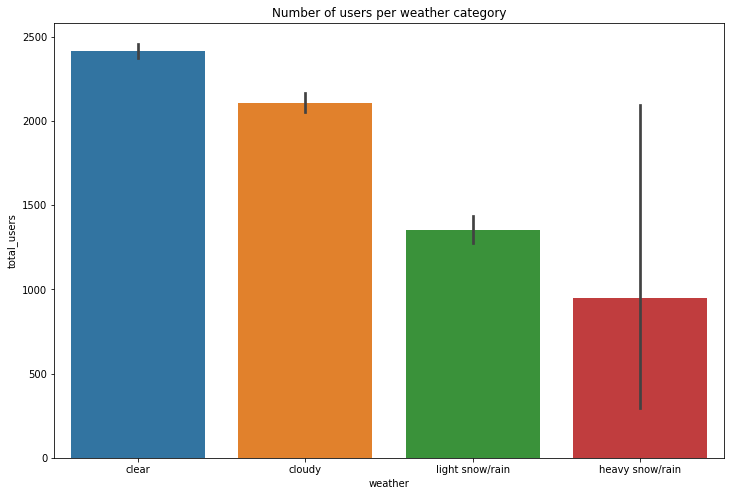

In [15]:
plt.figure(figsize=(12,8))
plt.title('Number of users per weather category')
sns.barplot(x='weather', y='total_users', data=df)

Since we observed that there might be a seasonal pattern for total users based on months and hours, let's create some new columns containing hours, day of week and months.

After which, we'll do a plot to see how it is.

In [16]:
# Creating a new column for hour
df['hour'] = [x.hour for x in df.index]

# Creating a new column for monnth
df['month'] = [x.month for x in df.index]

# Creating a new column for days in a week
df['day_week'] = [x.weekday() for x in df.index]
df['day_week'] = df['day_week'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun',})
df.head()

# Creating a new colkumn for days in a month
df['day_month'] = [x.day for x in df.index]

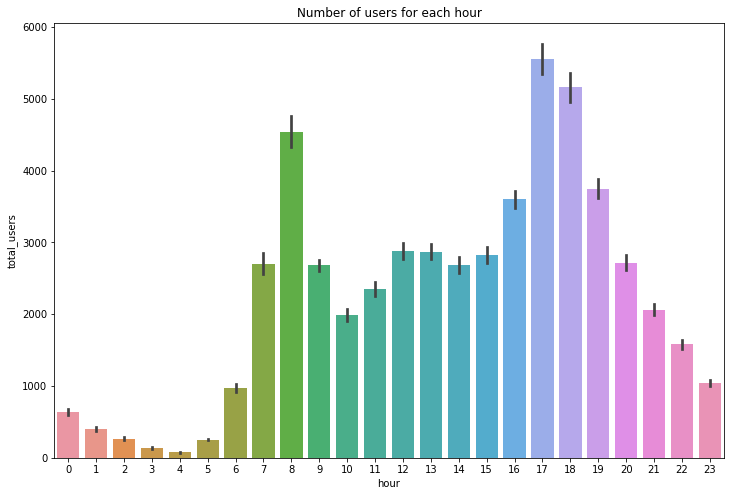

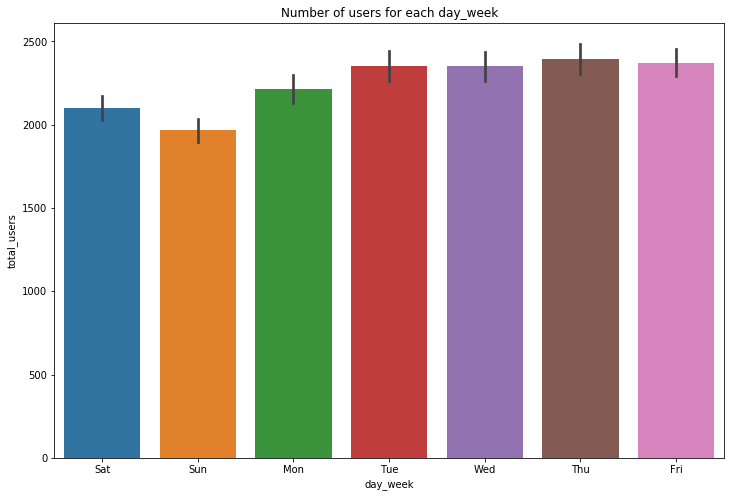

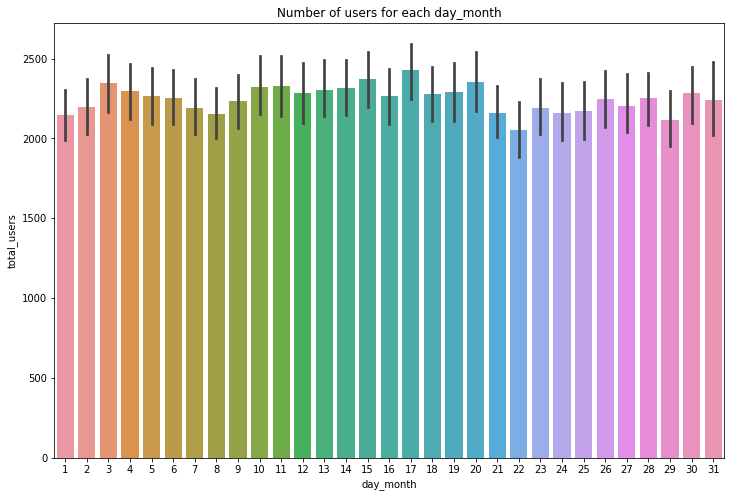

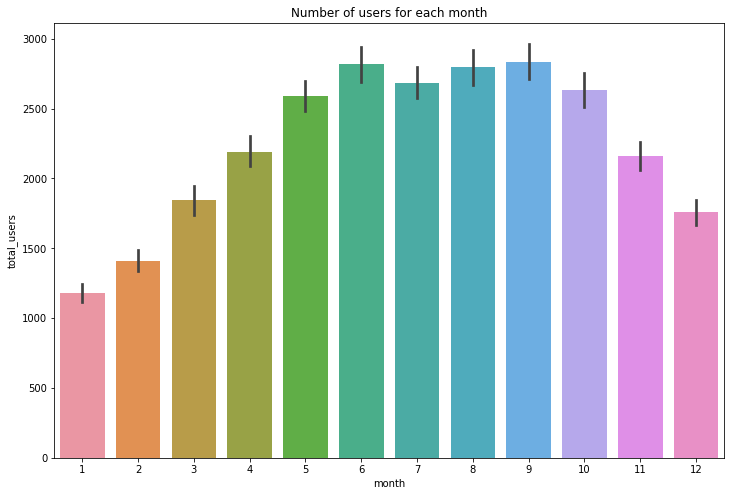

In [17]:
plottables = ['hour', 'day_week', 'day_month', 'month']

for period in plottables:
    plt.figure(figsize=(12,8))
    plt.title('Number of users for each ' + period)
    sns.barplot(x=period, y='total_users', data=df)

## Hour 
Clearly a trend can be identified. Peak periods of usage is during morning hours and evening hours.

## Day_Week
Usage drops during weekends. Perhaps suggesting that primary purpose of e-scooters are for working/school-going crowd to get around.

## Day_Month
Not much variation across different days in a month

## Month
Seasonal usage can be observed. Usage peaks in middle of the year, probably because of good weather (E.g. Summer)

## Conclusion

Columns to drop:
1. Temperature
2. Windspeed
3. PSI
4. day_month

In [18]:
# Dropping above data
df = df.drop(['temperature', 'windspeed', 'psi', 'day_month'], axis=1)
df.head()

,weather,feels-like-temperature,relative-humidity,total_users,hour,month,day_week
date-time,,,,,,,
2011-01-01 00:00:00,clear,95.0,81.0,185,0,1,Sat
2011-01-01 01:00:00,clear,93.2,80.0,471,1,1,Sat
2011-01-01 02:00:00,clear,93.2,80.0,391,2,1,Sat
2011-01-01 03:00:00,clear,95.0,75.0,148,3,1,Sat
2011-01-01 04:00:00,clear,95.0,75.0,8,4,1,Sat


# 4. Modelling

We'll try to model the data using two methods:

1. LightGBM Regressor
2. Random Forest Regressor
Since total users is a continuous variable, a regression based approach might be suitable.

I am not considering deep-learning models because the amount of data available (~18k rows) might not be sufficient. In such cases, it is likely that non deep-learning models will outperform deep-learning models.

Also, I have some doubts as to whether a time-series model will be effective, given that there is only data for 2 years.

In [62]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,r2_score

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17958 entries, 2011-01-01 00:00:00 to 2012-04-29 10:00:00
Data columns (total 7 columns):
weather                   17958 non-null object
feels-like-temperature    17958 non-null float64
relative-humidity         17958 non-null float64
total_users               17958 non-null int64
hour                      17958 non-null int64
month                     17958 non-null int64
day_week                  17958 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 1.7+ MB


In [21]:
# Creating binary columns for the previously categorical columns
for column in df.columns:
    if df[column].dtypes=='O':
        df = pd.concat([df,pd.get_dummies(df[column],drop_first=False)],axis=1)
        df.drop(column,axis=1,inplace=True)
df.head()

,feels-like-temperature,relative-humidity,total_users,hour,month,clear,cloudy,heavy snow/rain,light snow/rain,Fri,Mon,Sat,Sun,Thu,Tue,Wed
date-time,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,95.0,81.0,185,0,1,1,0,0,0,0,0,1,0,0,0,0
2011-01-01 01:00:00,93.2,80.0,471,1,1,1,0,0,0,0,0,1,0,0,0,0
2011-01-01 02:00:00,93.2,80.0,391,2,1,1,0,0,0,0,0,1,0,0,0,0
2011-01-01 03:00:00,95.0,75.0,148,3,1,1,0,0,0,0,0,1,0,0,0,0
2011-01-01 04:00:00,95.0,75.0,8,4,1,1,0,0,0,0,0,1,0,0,0,0


Splitting the data into train-test sets. I'll be using a training set of 80% and testing set of 20%.

In [25]:
features = [x for x in df.columns if x != 'total_users']
target = ['total_users']

x = df[features]
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Testing with LGBM Regressor - With close to no tuning, model is able to give a R2 score of 0.87. However, RSME at 771 seems to be on the high side, given that mean of total users is in the 2000s.

Notwithstanding that, it appears that the dataset has relatively good predictive strength.

In [70]:
lgbm = LGBMRegressor(learning_rate=0.1, n_estimators=2000)
lgbm.fit(x_train, y_train)
print('R2:', lgbm.score(x_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, lgbm.predict(x_test))))
print('CV:', np.average(cross_val_score(lgbm, x_train, y_train,cv=5)))

R2: 0.8715867504688207
RMSE: 771.6374660025473
CV: 0.8539501481426168


Let's use Random Forest Regressor and see if results will improve. 

As expected, LGBM outperforms Random Forest Regressor. LGBM is able to give a better R2 and RSME score.

In [39]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
print('R2:', rf.score(x_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf.predict(x_test))))
print('CV:', np.average(cross_val_score(rf, x_train, y_train, cv=5)))

R2: 0.8511914752682112
RMSE: 830.6580796619779
CV: 0.8262807052780838
